## Final Project Submission

Please fill out:
* Student name: Jacob Crabb/ Taeho Jeon
* Student pace: full time 
* Instructor name: Greg/Miles
* Blog post URL:


In [144]:
#import our libraries
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
from scipy.stats import linregress
import folium
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [145]:
pysqldf = lambda q: sqldf(q, globals())

In [77]:
#set our dataframe
df = pd.read_csv('kc_house_data.csv')

In [78]:
#check out some of the column values
print(df.condition.unique())

print(df.grade.unique())

[3 5 4 1 2]
[ 7  6  8 11  9  5 10 12  4  3 13]


In [79]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [80]:
#see what relates to what
df.corr().head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342


In [81]:
#look at the low end of values
df.price.sort_values().head()

15279    78000.0
465      80000.0
16184    81000.0
8267     82000.0
2139     82500.0
Name: price, dtype: float64

In [82]:
#make sure that all the values are numbers
df.price.isna().sum()

0

In [83]:
#check out just teh square foot living column
df.sqft_living.describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

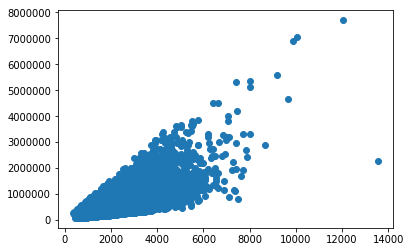

In [84]:
#set some variables for our first plot
X = df.sqft_living
y = df.price

plt.scatter(X, y)

In [85]:
#go for a more advanced attempt at least squares regression
slope, intercept, rvalue, pvalue, stderr = linregress(X,y)

first_model_y = slope*X + intercept

In [86]:
#check out our regression variables
linregress(X,y)

LinregressResult(slope=280.8630143588746, intercept=-43988.892194227315, rvalue=0.7019173021377599, pvalue=0.0, stderr=1.9394099144299841)

In [87]:
#look at our models outputs
first_model_y.describe()

count    2.159700e+04
mean     5.402966e+05
std      2.578621e+05
min      5.993042e+04
25%      3.576452e+05
50%      4.924595e+05
75%      6.722118e+05
max      3.758896e+06
Name: sqft_living, dtype: float64

In [88]:
#find upper quartile
df[df.price > 6.722118e+05].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
21,2524049179,8/26/2014,2000000.0,3,2.75,3050,44867,1.0,0.0,4.0,...,9,2330,720.0,1968,0.0,98040,47.5316,-122.233,4110,20336
26,1794500383,6/26/2014,937000.0,3,1.75,2450,2691,2.0,0.0,0.0,...,8,1750,700.0,1915,NaN,98119,47.6386,-122.360,1760,3573
29,1873100390,3/2/2015,719000.0,4,2.50,2570,7173,2.0,0.0,0.0,...,8,2570,0.0,2005,0.0,98052,47.7073,-122.110,2630,6026
32,461000390,6/24/2014,687500.0,4,1.75,2330,5000,1.5,0.0,0.0,...,7,1510,820.0,1929,0.0,98117,47.6823,-122.368,1460,5000


In [89]:
#find the lower quartile
df[df.price < 3.576452e+05].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113


In [90]:
#look at the low end of square foot
df.sqft_living.sort_values().tail()

8085      9640
9245      9890
3910     10040
7245     12050
12764    13540
Name: sqft_living, dtype: int64

In [91]:
#drop our first outlier
df = df.drop(index=12764)

In [92]:
#check to make sure it's gone
df.loc[df.index == 12764]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [93]:
#finding many outliers
remove_outliers = df.loc[(df.price >= 4500000) & (df.sqft_living >= 8000)].index

In [94]:
#remove those many outliers
df = df.drop(index=remove_outliers)

LinregressResult(slope=271.48382562201607, intercept=-25542.826878536027, rvalue=0.6956774973134765, pvalue=0.0, stderr=1.9080006609072122)


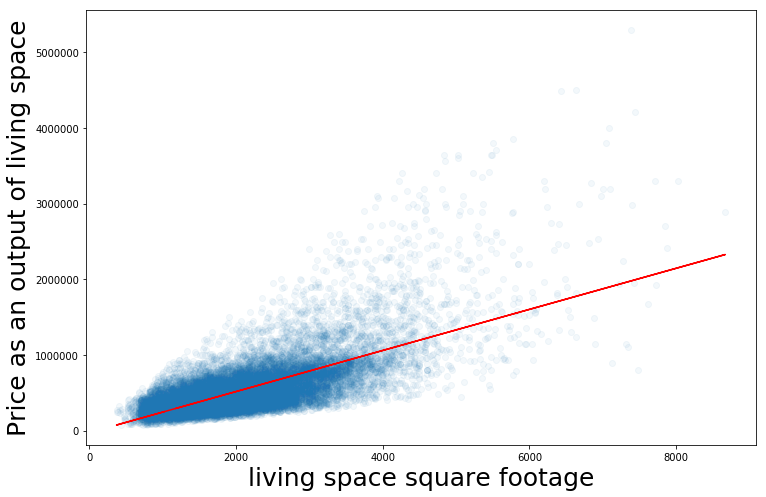

In [95]:
#see our new regression now that many extravaganatly
#large and expensive houses have been removed
X = df.sqft_living
y = df.price

slope, intercept, rvalue, pvalue, stderr = linregress(X,y)

first_model_y = slope*X + intercept

print(linregress(X,y))

fig = plt.figure(figsize=(12,8))
plt.scatter(X,y, alpha=0.05)
plt.plot(X, first_model_y, color='red')
plt.xlabel('living space square footage',fontsize=25)
plt.ylabel('Price as an output of living space',fontsize=25)
plt.show()

In [96]:
#write a function to return a prediction based on square footage
def return_predicted_value(x, slope, intercept):
    return slope*x + intercept

In [97]:
#see our results
return_predicted_value(8000, slope, intercept)

2146327.7780975928

In [98]:
df.lat.value_counts().head()

47.5322    17
47.6846    17
47.6624    17
47.5491    17
47.6886    16
Name: lat, dtype: int64

In [99]:
df.long.value_counts().head()

-122.290    115
-122.300    111
-122.362    104
-122.291    100
-122.372     99
Name: long, dtype: int64

# save this for tomorrow

In [100]:
#plot = df.plot(kind='scatter', x='long', y='lat', alpha=0.15, figsize=(10,10))
#points = list(zip(df.lat,df.long))
#m = folium.Map([47.53, -122.3], zoom_start=10)
#for point in points:
#    folium.CircleMarker(point[:500],
#                        radius=1,
#                        popup= 'point',
#                        fill_color="#3db7e4").add_to(m)
#m

In [101]:
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,10/13/2014,12/9/2014,2/25/2015,12/9/2014,2/18/2015
price,221900,538000,180000,604000,510000
bedrooms,3,3,2,4,3
bathrooms,1,2.25,1,3,2
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1,2,1,1,1
waterfront,NaN,0,0,0,0
view,0,0,0,0,0


In [102]:
df.yr_built = 2019 - df.yr_built

In [103]:
df = df.rename(columns={'yr_built': 'years_old'})

In [104]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'years_old', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [105]:
# _ = pd.plotting.scatter_matrix(df[['price', 'bedrooms', 'bathrooms', 
#                                   'sqft_living', 'floors', 'waterfront', 
#                                   'view', 'condition', 'years_old']], figsize=(12, 12))

In [106]:
def do_predict(X, y):
    """Takes array like objects for X and y"""
    
    #run a train test split on our variables
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=0.2,
                                                       random_state=27)
    #perform our regression and fit
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    #set a variable to our r squared for our test set
    r2_score = lr.score(X_test, y_test)
    
    #set a variable to our test prediction
    y_pred = lr.predict(X_test)
    
    #variable for mean squared error
    mse = mean_squared_error(y_test, y_pred)
    
    #variable for our root mean squared error
    rmse = np.sqrt(mse)
    
    #perform a cross validation with our data set
    scores = cross_val_score(lr, X, y,
                            scoring='neg_mean_squared_error', cv=10)
    
    #root mean squared error result of our cross validation
    rmse_scores = np.sqrt(-scores)
    
    
    #return a dictionary with our final values
    return lr, {'R2':  r2_score,
            'RMSE':  rmse,
            'RMSE_SCORES':   rmse_scores,
            'Mean':  rmse_scores.mean(),
            'Std':  rmse_scores.std()
            }

In [107]:
#set the view NaN's to 0 since it's by
#far the most common value
df.view.replace(to_replace=np.NaN, value=0, inplace=True)

df.sqft_basement.replace(to_replace='?', value=0, inplace=True)
df.sqft_basement = df.sqft_basement.astype('float64')
df.waterfront.replace(to_replace=np.NaN, value=0, inplace=True)
df.yr_renovated.replace(to_replace=np.NaN, value=0, inplace=True)

In [108]:
X = df.drop(columns=['price','date','id','yr_renovated'], axis=1)

y = df.price

# Goals:
day 2: try multivariable regression with variables that have low multicolinearity, try to build a function that finds how far away it is from here. do some more data exploration and cleaning. work zipcodes into dummy columns so we can see things like price by zipcode. treat building grade as catagorical if it's not already. for now we will base off of rmse

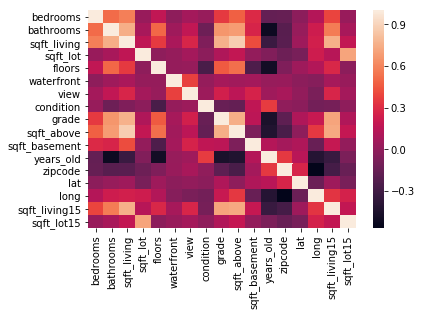

In [109]:
sns.heatmap(X.corr())

things that we're not using: bathrooms, bedrooms, sqft_living_15

things to include: sqft_living, condition,view,waterfront,

In [110]:
print(do_predict(X,y))

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.7039904343806925, 'RMSE': 188196.97684529508, 'RMSE_SCORES': array([193120.60459392, 201651.60523073, 175431.96990221, 200697.99867921,
       164628.95314942, 190268.24030927, 186351.25707596, 196480.29238917,
       202779.68488868, 214156.02580165]), 'Mean': 192556.66320202182, 'Std': 13611.432330162374})


In [111]:
X = df.drop(columns=['price','date','id','yr_renovated','years_old', 'floors', 'sqft_above'], axis=1)

y = df.price

In [112]:
do_predict(X,y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.6811718197283265,
  'RMSE': 195316.13430102245,
  'RMSE_SCORES': array([201169.13767319, 210664.40045781, 185498.46886755, 208390.11448466,
         173929.75492843, 197809.22124177, 195521.58372001, 203801.2872722 ,
         210689.08421933, 209111.16347003]),
  'Mean': 199658.42163349787,
  'Std': 11449.24013486175})

In [113]:
X = df.loc[:,['sqft_living']]
y = df.price

In [114]:
do_predict(X,y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.4907616031350701,
  'RMSE': 246842.73007882628,
  'RMSE_SCORES': array([257449.79572394, 265579.77714454, 238808.82691858, 263302.59132767,
         227291.57558004, 246712.89805713, 247562.11331225, 259454.31635127,
         262030.63588889, 266349.61207982]),
  'Mean': 253454.2142384131,
  'Std': 12308.392365238155})

In [115]:
df.zipcode.value_counts().size

70

In [117]:
df['Seattle_zip'] = 0


In [118]:
X = df.loc[:,['sqft_living','condition', 'view', 'waterfront']]
y = df.price

In [119]:
do_predict(X,y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.5530912321545016,
  'RMSE': 231243.3261214612,
  'RMSE_SCORES': array([234837.94652397, 249179.83681749, 222548.99984054, 245857.77152977,
         214573.14555829, 233199.61641218, 233578.96292344, 243138.77516911,
         246781.12685435, 253451.69245633]),
  'Mean': 237714.78740854803,
  'Std': 11697.557906935372})

# numbers to beat
{'R2': 0.7039904343806925, 'RMSE': 188196.97684529508, 'RMSE_SCORES': array([193120.60459392, 201651.60523073, 175431.96990221, 200697.99867921,
       164628.95314942, 190268.24030927, 186351.25707596, 196480.29238917,
       202779.68488868, 214156.02580165]), 'Mean': 192556.66320202182, 'Std': 13611.432330162374}

In [120]:
X = df.drop(columns=['price','date','id'], axis=1)

y = df.price

In [121]:
lr, result = do_predict(X,y)

In [122]:
lr.coef_

array([-2.86831365e+04,  3.79444206e+04,  1.01921124e+02,  1.85538958e-01,
        1.47307651e+04,  6.10593238e+05,  5.42252288e+04,  2.75075644e+04,
        1.00720595e+05,  5.26541053e+01,  2.75163636e+01,  2.60767426e+03,
        2.45866766e+01, -5.61070438e+02,  6.03248668e+05, -2.06776097e+05,
        3.44776309e+01, -3.82456275e-01,  0.00000000e+00])

In [125]:
def is_it_in_seattle(x):
    seattle_zip_codes = [98101, 98102, 98104, 98105, 98108, 98109, 98112 ,98113, 98114,
                     98117, 98103, 98106, 98107, 98111, 98115, 98116, 98118, 98119,
                     98121, 98125, 98126, 98132, 98133, 98138, 98139, 98141, 98122,
                     98124, 98127, 98129, 98131, 98134, 98136, 98144, 98145, 98148,
                     98155, 98160, 98161, 98164, 98165, 98168, 98170, 98146, 98154,
                     98158, 98166, 98174, 98175, 98178, 98190, 98191, 98177, 98181,
                     98185, 98188, 98189, 98194, 98195, 98199, 98198]
    return x in seattle_zip_codes

In [126]:
is_it_in_seattle(98101)

True

In [131]:
df.loc[df['zipcode'].apply(is_it_in_seattle) == True, 'Seattle_zip'] = 1

In [140]:
X = df.loc[:,['sqft_living','condition', 'view', 'waterfront']]
y = df.price

do_predict(X, y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.5530912321545016,
  'RMSE': 231243.3261214612,
  'RMSE_SCORES': array([234837.94652397, 249179.83681749, 222548.99984054, 245857.77152977,
         214573.14555829, 233199.61641218, 233578.96292344, 243138.77516911,
         246781.12685435, 253451.69245633]),
  'Mean': 237714.78740854803,
  'Std': 11697.557906935372})

In [138]:
X = df.loc[df['Seattle_zip'] == 1,['sqft_living','condition', 'view', 'waterfront']]
y = df.price[df['Seattle_zip'] == 1]

do_predict(X, y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.5394131799873588,
  'RMSE': 212221.02580439238,
  'RMSE_SCORES': array([216117.64286664, 241451.30868234, 221212.97782964, 226328.56634387,
         214816.67276689, 226922.56177503, 224195.21861831, 224251.1113331 ,
         236310.52207928, 201140.78947549]),
  'Mean': 223274.73717706045,
  'Std': 10684.932728636739})

In [141]:
X = df.loc[df['Seattle_zip'] == 0,['sqft_living','condition', 'view', 'waterfront']]
y = df.price[df['Seattle_zip'] == 0]

do_predict(X, y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.5789857080093423,
  'RMSE': 234868.52650233018,
  'RMSE_SCORES': array([232374.3201982 , 251086.22664367, 221403.22223006, 231585.23310143,
         216842.04566723, 229628.47633311, 226998.41190233, 242242.02639968,
         243562.23068913, 266486.22073857]),
  'Mean': 236220.8413903404,
  'Std': 14096.170277885016})

In [185]:
def get_dataframe_by_zip(x):
    q = f"SELECT * FROM df WHERE zipcode={x}"
    return pysqldf(q)
    

98178
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.7690219952202392, 'RMSE': 52733.609439622785, 'RMSE_SCORES': array([140769.65258174,  69416.83826511,  52975.10194916,  52821.91048185,
        48140.57263099,  66638.64512888,  44097.19100715,  79492.239635  ,
        68953.2256488 ,  69186.28238266]), 'Mean': 69249.16597113227, 'Std': 26153.258824239783})
98125
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.7010960673832557, 'RMSE': 82676.51147753256, 'RMSE_SCORES': array([106148.60319368,  72762.37960442, 117190.64072337,  65720.72958735,
        92696.09103897,  74778.33384229,  62236.41600509, 198450.54727103,
       133690.23201386,  63106.07551039]), 'Mean': 98678.00487904354, 'Std': 40665.8020269277})
98028
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.6620961775250699, 'RMSE': 122929.68628337771, 'RMSE_SCORES': array(

98030
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.6597944040172954, 'RMSE': 37440.89081589107, 'RMSE_SCORES': array([31892.51759437, 51578.26706739, 28814.35771072, 33545.59523422,
       36096.35090306, 40060.42349618, 48951.96581395, 43061.49046903,
       37334.03055549, 38293.48986567]), 'Mean': 38962.84887100944, 'Std': 6859.888934353113})
98119
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.40440536527679094, 'RMSE': 247160.32390573592, 'RMSE_SCORES': array([129416.37507908, 192837.20260022, 233930.44360362, 256319.95604909,
       144159.73244064, 113867.42696749, 337171.04731491, 151267.71574322,
       228144.13301015, 346352.05808727]), 'Mean': 213346.60908956872, 'Std': 78430.83002372432})
98112
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.775756725057863, 'RMSE': 286409.20968403324, 'RMSE_SCORES': array([215580.9

98005
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.7970254573144837, 'RMSE': 107970.0881312192, 'RMSE_SCORES': array([135915.43562133, 160853.48575408,  78951.02229869, 164486.92684171,
       127261.93031016, 168088.85100401, 203551.91770013, 159419.60984754,
       113260.90936031, 157340.09107291]), 'Mean': 146913.01798108718, 'Std': 32685.023802217733})
98034
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.6926243952021116, 'RMSE': 202472.286550097, 'RMSE_SCORES': array([122366.57329995, 250589.06691415, 149174.12591978,  75539.53169432,
       142684.88110193,  93763.66912236,  83723.96158144, 125298.98912227,
       156719.25338097, 212628.08426509]), 'Mean': 141248.81364022658, 'Std': 52770.34377539442})
98075
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.8284638199767975, 'RMSE': 137471.3745999424, 'RMSE_SCORES': array(

98155
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.5237027851499461, 'RMSE': 140850.96359937426, 'RMSE_SCORES': array([127621.53364529, 374709.71927204,  89163.21318688, 117371.23326845,
        92957.90668231,  79898.06185365,  97240.67160211, 264130.40577455,
        65938.96397037,  83750.25173504]), 'Mean': 139278.19609907045, 'Std': 94891.56931557241})
98024
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.6725993776541493, 'RMSE': 188974.88742954587, 'RMSE_SCORES': array([ 90136.37806285, 152189.15162232,  91122.71424366, 201294.66586984,
        54540.92941323, 174425.51418356, 150370.55440769,  66763.25917937,
       328175.38238806, 146657.71834306]), 'Mean': 145567.62677136538, 'Std': 76082.08316407252})
98011
(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), {'R2': 0.7797171767829263, 'RMSE': 58512.47280552181, 'RMSE_SCORES': arra

In [ ]:
result.price

In [195]:
zip_result = []
for zipcode in df.zipcode.unique():
    zip_df = get_dataframe_by_zip(zipcode)
    
    X = zip_df.drop(columns=['price','date','id'], axis=1)
    y = zip_df.price

    model, result = do_predict(X, y)
    zip_result.append((zipcode, result['Mean']))


In [199]:
zip_result

[(98178, 69249.16597113227),
 (98125, 98678.00487904354),
 (98028, 80457.15139651476),
 (98136, 116792.5249199261),
 (98074, 108280.35602517167),
 (98053, 101001.51581267398),
 (98003, 50401.73182971057),
 (98198, 79583.59293074938),
 (98146, 89589.51915675904),
 (98038, 61246.23622251976),
 (98007, 70882.59162944261),
 (98115, 121696.06066490445),
 (98107, 139283.5279407823),
 (98126, 70600.74845586755),
 (98019, 63869.024488567185),
 (98103, 105466.4117010654),
 (98002, 28673.797677121758),
 (98133, 67238.83677162131),
 (98040, 261325.60483451298),
 (98092, 56400.858305981536),
 (98030, 38962.84887100944),
 (98119, 213346.60908956872),
 (98112, 233961.2943522578),
 (98052, 92779.52277490089),
 (98027, 123238.1889558922),
 (98117, 94794.62718782497),
 (98058, 60375.933570909096),
 (98001, 46932.58874652117),
 (98056, 92030.6604441973),
 (98166, 137991.80713769962),
 (98023, 55158.86687754097),
 (98070, 132971.39253971865),
 (98148, 59953.155332371636),
 (98105, 151426.66178275383),
 (

In [219]:
zip_result[0][1]

69249.16597113227

In [246]:
np.arange(0, 1, step=0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

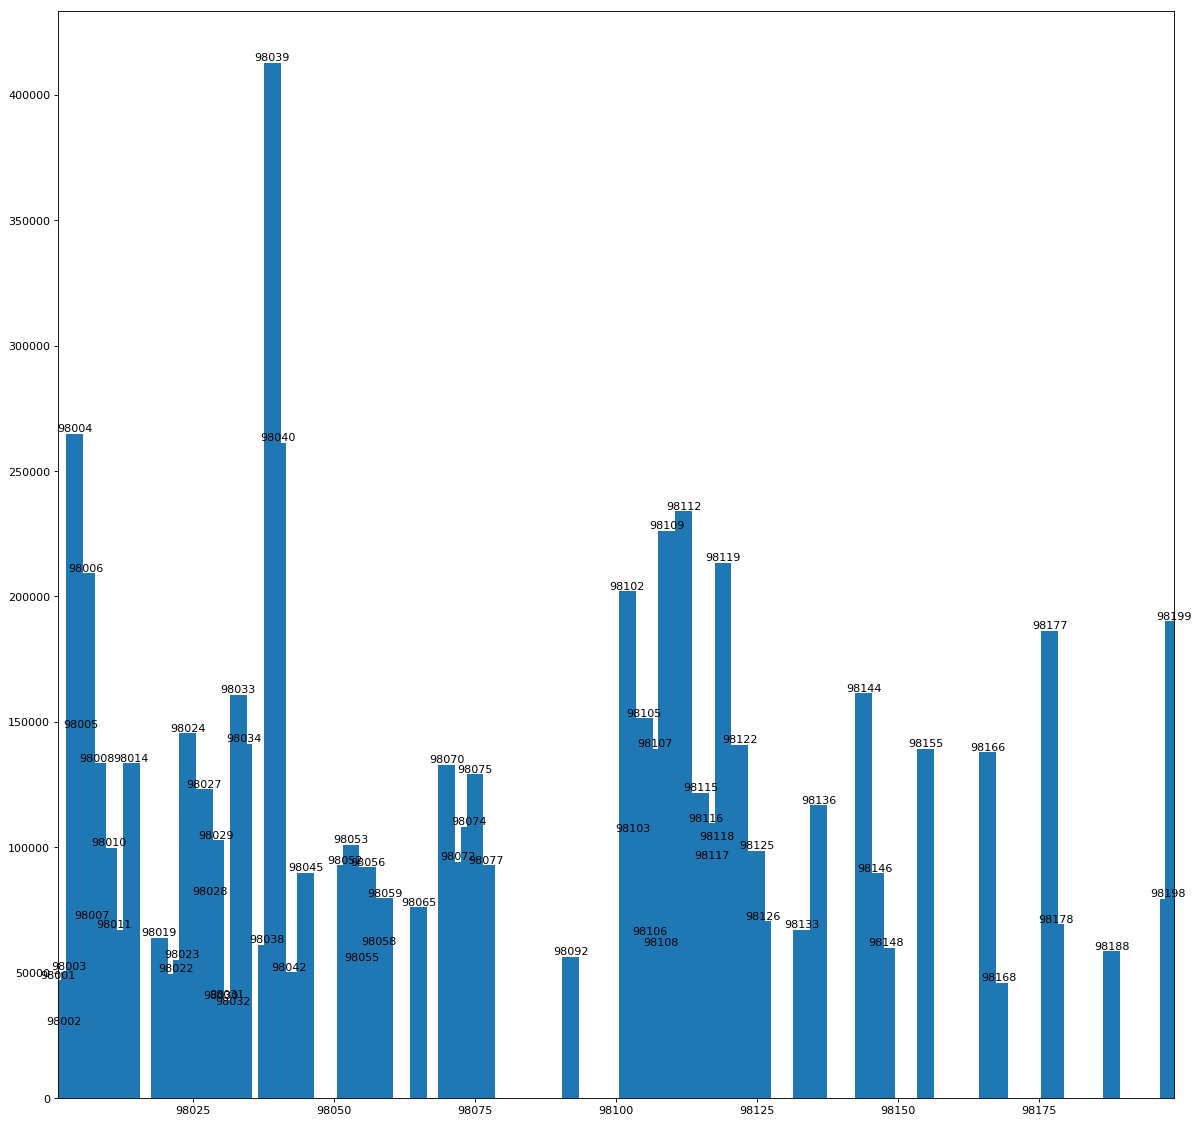

In [271]:
fig, ax = plt.subplots(figsize=(18, 18), dpi=80)

zipcodes = []
rmses = []
for zipcode, mean_rmse in zip_result:
    zipcodes.append(zipcode)
    rmses.append(mean_rmse)

ax.bar(zipcodes, rmses, width=3)
ax.set_xbound(lower=98001, upper=df.zipcode.max())
rects = ax.patches

for rect, label in zip(rects, zipcodes):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
           ha='center', va='bottom')